## Tutorial: Circuits I
 * How to initialize an `AtomicSystem`
 * Construct and visualize a `QuantumCircuit` out of `StandardGates`
 * Simulate the circuit without losses and analyse results through `Simulator`

### Two qubit system

Load a default experimental setup configuration

In [2]:
from rysp.core.experiment import ExperimentSetup

# TODO: relative file location
exp = ExperimentSetup.fromFile('template_hardware_pulsed.json')

#### Constructing an atomic system

We start by initializing an empy `AtomSystem`, and add new atoms onto the desired positions

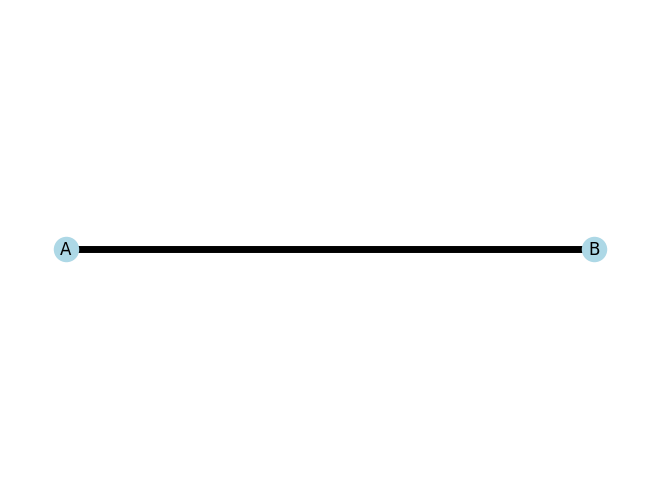

In [3]:
import numpy as np
from rysp.core.experiment import AtomSystem

# Define the unit distance of the system to be 4 \mu m
lattice_unit = 4e-6 # All units are in S.I.

atomsys = AtomSystem()
atom = exp.get_atom()
atomsys.add_atom('A', atom, lattice_unit*np.array([0,0,0]))
atomsys.add_atom('B', atom, lattice_unit*np.array([1,0,0]))

from rsp.utils.visualize import plot_atom_lattice
import matplotlib.pyplot as plt
plot_atom_lattice(atomsys)
plt.show()


##### Usage docstring

In [4]:
# Show the docstring with usage instructions
from rsp.core.experiment import AtomSystem
AtomSystem.add_atom?

Signature:
AtomSystem.add_atom(
    self,
    label: str,
    atom: rsp.core.experiment.atom.AtomInTrap,
    position: numpy.ndarray,
)
Docstring:
add_atom Adds a new atom onto the system, 
with a given (unique) label as identification. 

Parameters
----------
label : str
    Unique label for the atom
atom : AtomInTrap
    Atom object loaded from the experimental setup
position : np.ndarray[float]
    Atom position in SI units (m)
File:      ~/Projects/strontium-simulation-platform/src/rsp/core/experiment/atomsystem.py
Type:      function

#### Quantum Circuit

Lets use the predefined gates `StandardGates` to run a simple example circuit

We start by loading the default gates 
 * $X$ : state flip on the clock ( $0\rightarrow 1$ ) transition ($\pi$ rotation)
 * $X_r$ : $\pi$ rotation on the rydberg transition ($1\rightarrow r$)
 * $Z$ : phase flip on the $0\rightarrow 1$ transition (eg: $Z\ket{+} = \ket{-}$)
 * $H$ : Hadamard gate on the $0\rightarrow 1$ transition
 * $CZ$ : phase entangling gate using the Rydberg blockade mechanism


In [5]:
from rysp.core.circuit import QuantumCircuit
from rysp.core.circuit.gatedictionary import GateDictionary

sg = GateDictionary(exp)
qc = QuantumCircuit('pulsed')

# Loading gates into quantum circuit
for gate in ['X', 'Xr', 'Z', 'H', 'CZ']:
    sg.load_gate(qc, gate)

##### Looking into the pulse shapes

The default gates are simply constructed from square pulses

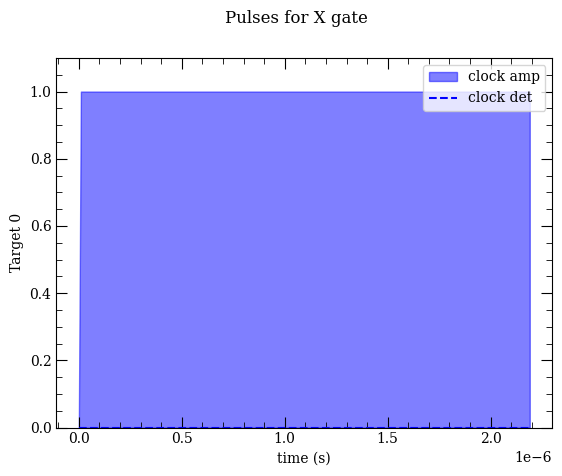

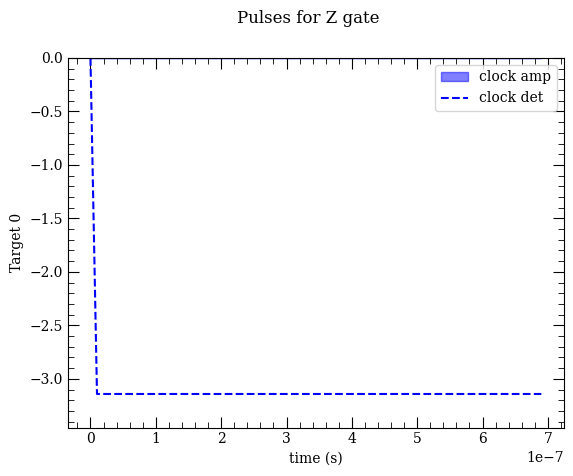

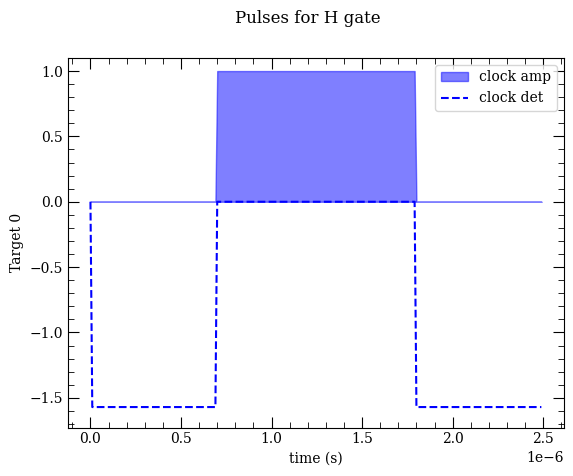

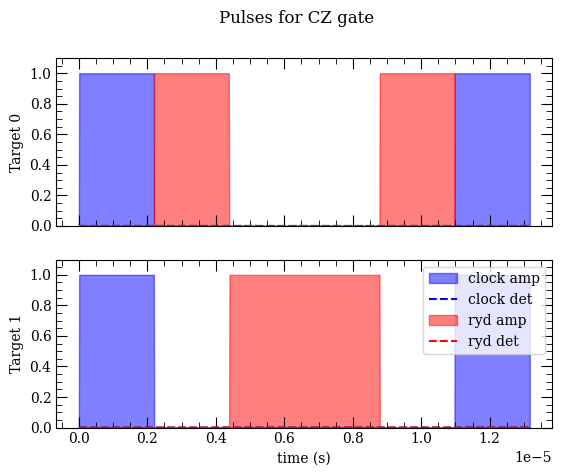

In [6]:
from rysp.utils.visualize import plot_pulsed_gate
import matplotlib.pyplot as plt

plot_pulsed_gate(sg.X('01'))
plt.suptitle('Pulses for X gate')
plt.legend()

plot_pulsed_gate(sg.Z('01'))
plt.suptitle('Pulses for Z gate')
plt.legend()

plot_pulsed_gate(sg.H('01'))
plt.suptitle('Pulses for H gate')
plt.legend()

plot_pulsed_gate(sg.CZ())
plt.suptitle('Pulses for CZ gate')
plt.legend()
plt.show()

#### Define the gate sequence


Lets try to simulate the blockade interaction

In [7]:
qc.reset()

qc.add_operation('X', ['A']) # 0 -> 1
qc.add_operation('X', ['B']) # 0 -> 1

qc.add_operation('Xr', ['A']) # 1 -> r
qc.add_operation('Xr', ['B']) # 1 -> Cr
qc.add_operation('Xr', ['B']) # r -> 1
qc.add_operation('Xr', ['A']) # r -> 1
qc.add_operation('X', ['A']) # 1 -> 0
qc.add_operation('X', ['B']) # 1 -> 0


KeyError: 'pG'

##### Showing the gate sequence 

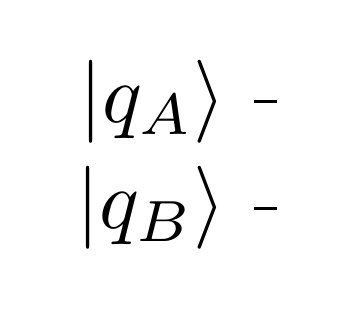

In [8]:
from rysp.utils.visualize import plot_quantum_circuit
from IPython.display import Image
imgname = plot_quantum_circuit(qc, {'A':'q_A', 'B': 'q_B'})
Image(filename=imgname, retina=True)

#### Simulating the quantum circuit

In [9]:
from rysp.core.simulation import Simulator
from timeit import default_timer as timer

sim = Simulator(exp, atomsys)

print("Running simulation...")
start = timer()
sim.run_circuit(qc, save_states=True)
print(f"Simulation took {timer()-start:.3} s")

Running simulation...
Simulation took 0.000971 s


For large circuit depth/width, the simulation run time will increase substantially. In the following chapter ([`Circuits II`](files/../Circuits%20II.ipynb)) we will talk about how the evolution can be cached for a much faster simulation.

In the meantime, lets look at the simulation results


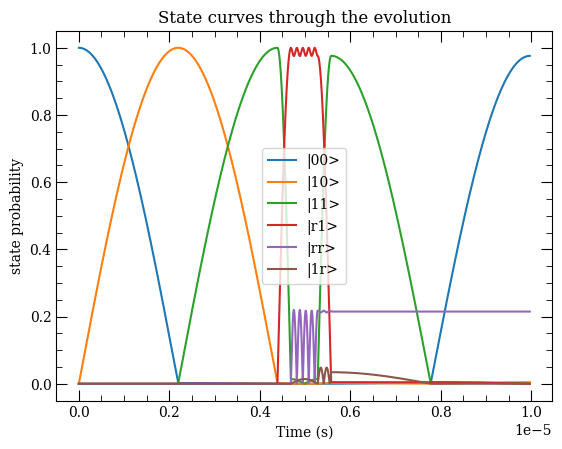

In [ ]:
from rysp.utils.state_view import show_state_evol

show_state_evol(sim.saved_states_times[::3], sim.saved_states[::3], 
                ['00', '10', '11', 'r1', 'rr', '1r'], atomsys)

plt.title("State curves through the evolution")
plt.ylabel("state probability")
plt.xlabel("Time (s)")
plt.show()

In [ ]:
from rysp.utils.state_view import interactive_state_plot

interactive_state_plot(sim.saved_states, sim.saved_states_times)

interactive(children=(IntSlider(value=0, description='ti', max=9972), Output(layout=Layout(height='600px'))), …

[comment on the plot results: fidelity]

After the Rydberg entangling sequence ($X_{r, A}, X_{r, B}$) there is some remaining rydberg population. This is because atom $A$ was not able to completely block the transition of atom $B$. You can learn more about the blockade process in [`Physics`](files/../Physics.ipynb).

The parameter which indicates the blockade infidelity is $ (2\Omega/V)^2$

In [ ]:
omega = exp.rabi_freq[('1','r')]
v = atom.c6_coef_dict[('r', 'r')]/(lattice_unit**6)

print(f"Blockade infidelity is {(2*omega/v)**2:.4}")  

Blockade infidelity is 0.2031


The blockade infidelity gives an upper bound for the population that remains in $\ket{rr}$.